In [1]:
from library.Accessor import Accessor
from library.attributionUtils import get_attributes,adversarial_detection_set
from library.attributions import multiply_attributed_with_input,number_of_active_nodes
from library.train import binary_acc

import torch
import numpy as np

2023-09-28 14:15:40.965798: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 14:15:41.042354: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-28 14:15:41.042373: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-09-28 14:15:41.430030: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
dataset = 'mnist' # can be mnist, cifar10, cuckoo, ember
model_name = 'mnist_1' # can be 'cifar10_1','cuckoo_1','Ember_2','mnist_1','mnist_2','mnist_3'
attack= 'FGSM' # can be 'FGSM','CW','PGD',"CKO",'EMBER'

In [3]:
test_benign_accessor = Accessor('./Benign/'+dataset+'/' +model_name +'/')
test_adv_accessor= Accessor('./Adversarial/'+dataset+'/'+attack +'/' +model_name +'/' )
#ground_truth_accessor = Accessor('./Ground_truth/mnist/mnist_1')

print('Loading Benign testing activations...')
test_benign_act = test_benign_accessor.get_all()
print('Loading Adversarial testing activations...')
test_adv_act = test_adv_accessor.get_all()
#gt_sample_act = ground_truth_accessor.get_all()



# Transforms the activations to the folowing data set : x[activationA,activaitonB,...]  y= [1, 0 ,1...]
X_adv,Y_adv = adversarial_detection_set(test_adv_act,label = torch.tensor(1.0))
X_ben,Y_ben = adversarial_detection_set(test_benign_act,label = torch.tensor(0.0))
#X_gt ,Y_gt =adversarial_detection_set(gt_sample_act,label = torch.tensor(0),expected_nb_nodes=expected_nb_nodes)



Loading Benign testing activations...
Loaded all activations for ./Benign/mnist/mnist_1/
Loading Adversarial testing activations...
Loaded all activations for ./Adversarial/mnist/FGSM/mnist_1/


In [4]:
## Testing model on test data
# We sample equal number of adversarial and benign data ...
shape_min = np.min([X_adv.shape[0],X_ben.shape[0]])
X_test = torch.cat((X_adv[:shape_min],X_ben[:shape_min]))# + X_gt
Y_test= torch.cat((Y_adv[:shape_min], Y_ben[:shape_min]))# + Y_gt

print('Shape of testing adv activations:',X_adv.shape)
print('Shape of testing ben activations:',X_ben.shape)

model = torch.load('./models/mnist_1_graph.pt')

X_test=torch.Tensor(X_test)
Y_test=torch.Tensor(Y_test)

if torch.cuda.is_available():
    model=model.cuda()
    X_test=X_test.cuda()
    Y_test=Y_test.cuda()
    

    
model.eval()
y_pred = model(X_test)

acc = binary_acc(y_pred, Y_test.unsqueeze(1))#(y_pred.round() == Y_test).float().mean()
acc = float(acc)
print('Model accuracy: ',float(acc))

Shape of testing adv activations: torch.Size([9857, 1204])
Shape of testing ben activations: torch.Size([9795, 1204])
Model accuracy:  100.0


In [5]:
## Performing adv and benign data feature attribution on the model
'''Attribution is performed with respect to the label 0 (benign)
If the attribute is postive: the node is directed to the label 0, 
otherwise it is directed to the label 1'''
    
adv_mul, adv_attr =multiply_attributed_with_input(X_adv,Y_adv,model)
ben_mul, ben_attr =multiply_attributed_with_input(X_ben,Y_ben,model)


avg_adv = [np.average(torch.Tensor.cpu(i)) for i in adv_attr]
avg_ben = [np.average(torch.Tensor.cpu(i)) for i in ben_attr]
#gt_attr = [np.average(i) for i in gt_attr]

print(f'Average Attributes of Adversarial samples:{np.average(avg_adv)} \nAverage Attributes of Benign samples: {np.average(avg_ben)}')# Gt : {np.average(gt_attr)} ')


For n_steps = 100, delta is  tensor([ 0.0018, -0.0031,  0.0003,  ...,  0.0017,  0.0008,  0.0034],
       device='cuda:0', dtype=torch.float64)


OutOfMemoryError: CUDA out of memory. Tried to allocate 8.79 GiB (GPU 0; 23.65 GiB total capacity; 9.41 GiB already allocated; 3.97 GiB free; 18.00 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
from library.attributionUtils import get_nodes_data

# nodes characteristics of adv data
adv_weights,adv_atts, adv_avg_weights, adv_avg_atts = get_nodes_data(X_adv, adv_attr)

# nodes characteristics of Benign data
ben_weights,ben_atts, ben_avg_weights, ben_avg_atts = get_nodes_data(X_ben, ben_attr)

In [ ]:
import matplotlib.pyplot as plt

x_axis = range(X_adv.shape[1]) # Nodes

def bar_plot(x_axis, y_ben, y_adv, x_label, y_label, title, xticks=None):
    
    # set width of bar
    barWidth = 0.25
    fig = plt.subplots(figsize =(30, 18))
    
    # set x positions
    x_ben = [x - barWidth for x in x_axis]
    x_adv = [x + barWidth for x in x_axis]
    
    plt.bar(x_adv, y_adv,color ='r', width = barWidth,
        edgecolor ='red', label ='Adv')
    
    plt.bar(x_ben, y_ben,color ='green', width = barWidth,
        edgecolor ='green', label ='Benign')
    
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if xticks != None:
        plt.xticks(x_axis,labels=xticks,rotation='vertical')
    plt.legend()
    plt.show()

NameError: name 'X_adv' is not defined

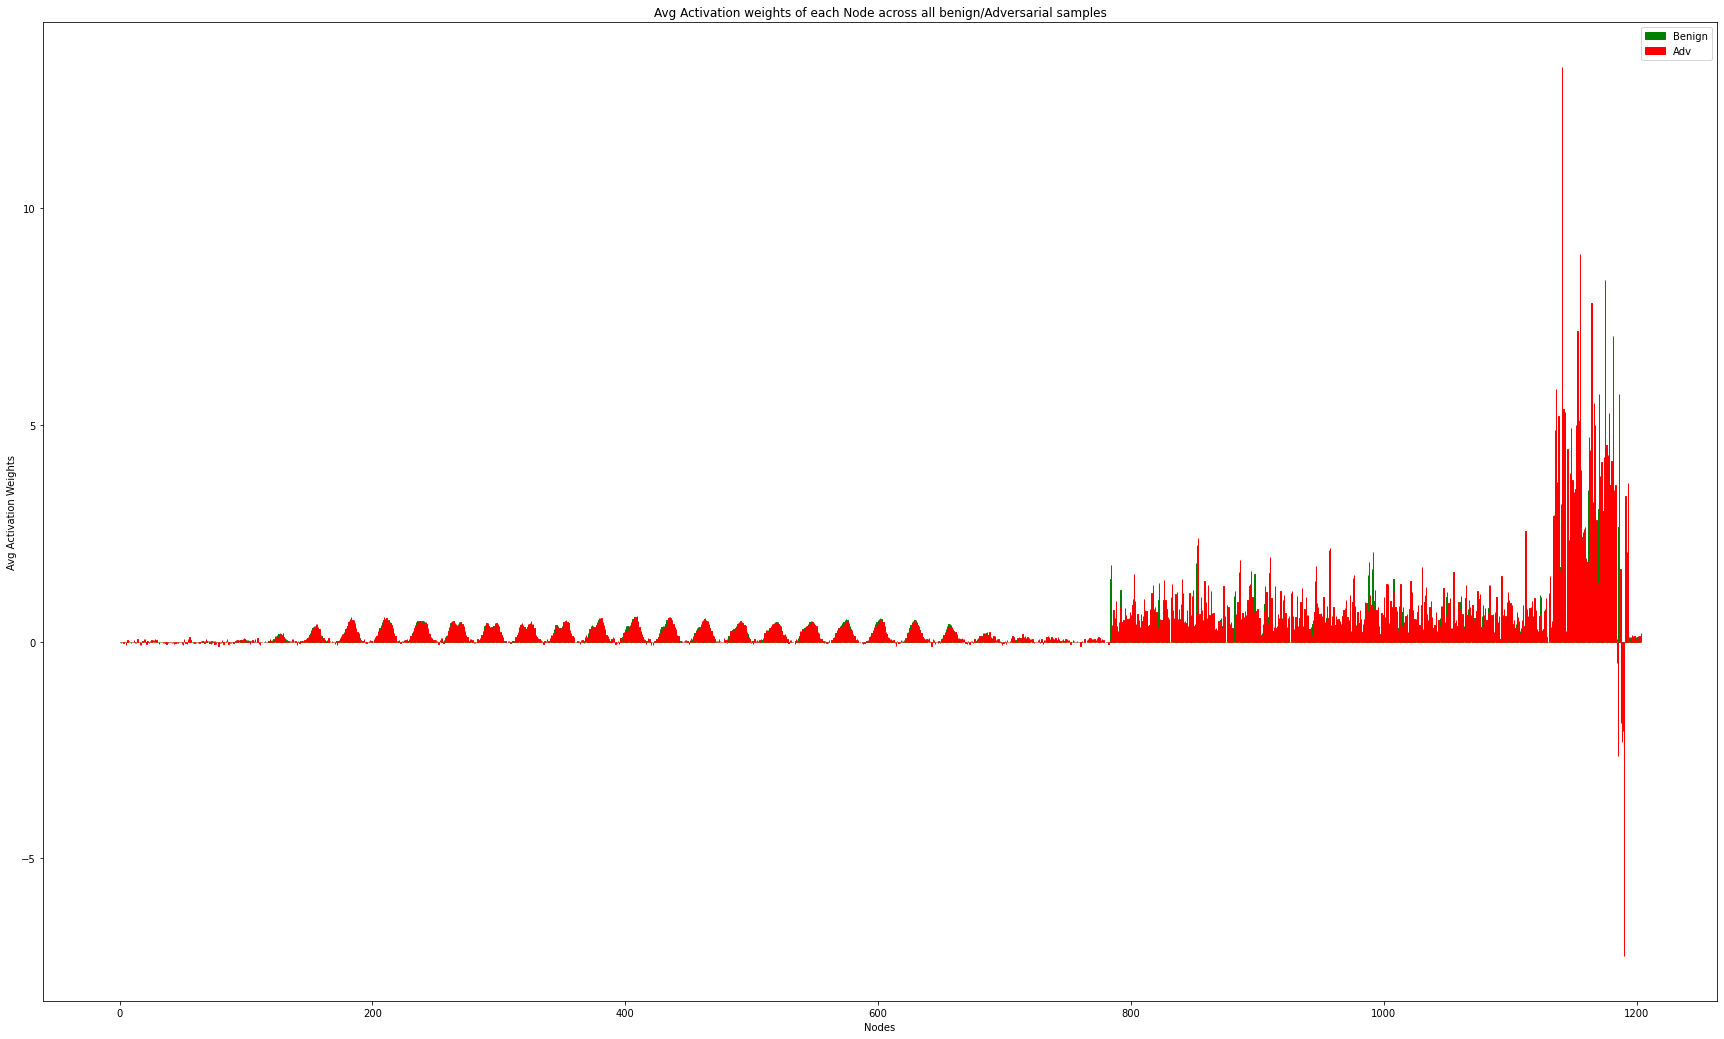

In [ ]:
# plot avg weights of all nodes
bar_plot(x_axis,ben_avg_weights,adv_avg_weights, 'Nodes', 'Avg Activation Weights', 'Avg Activation weights of each Node across all benign/Adversarial samples')

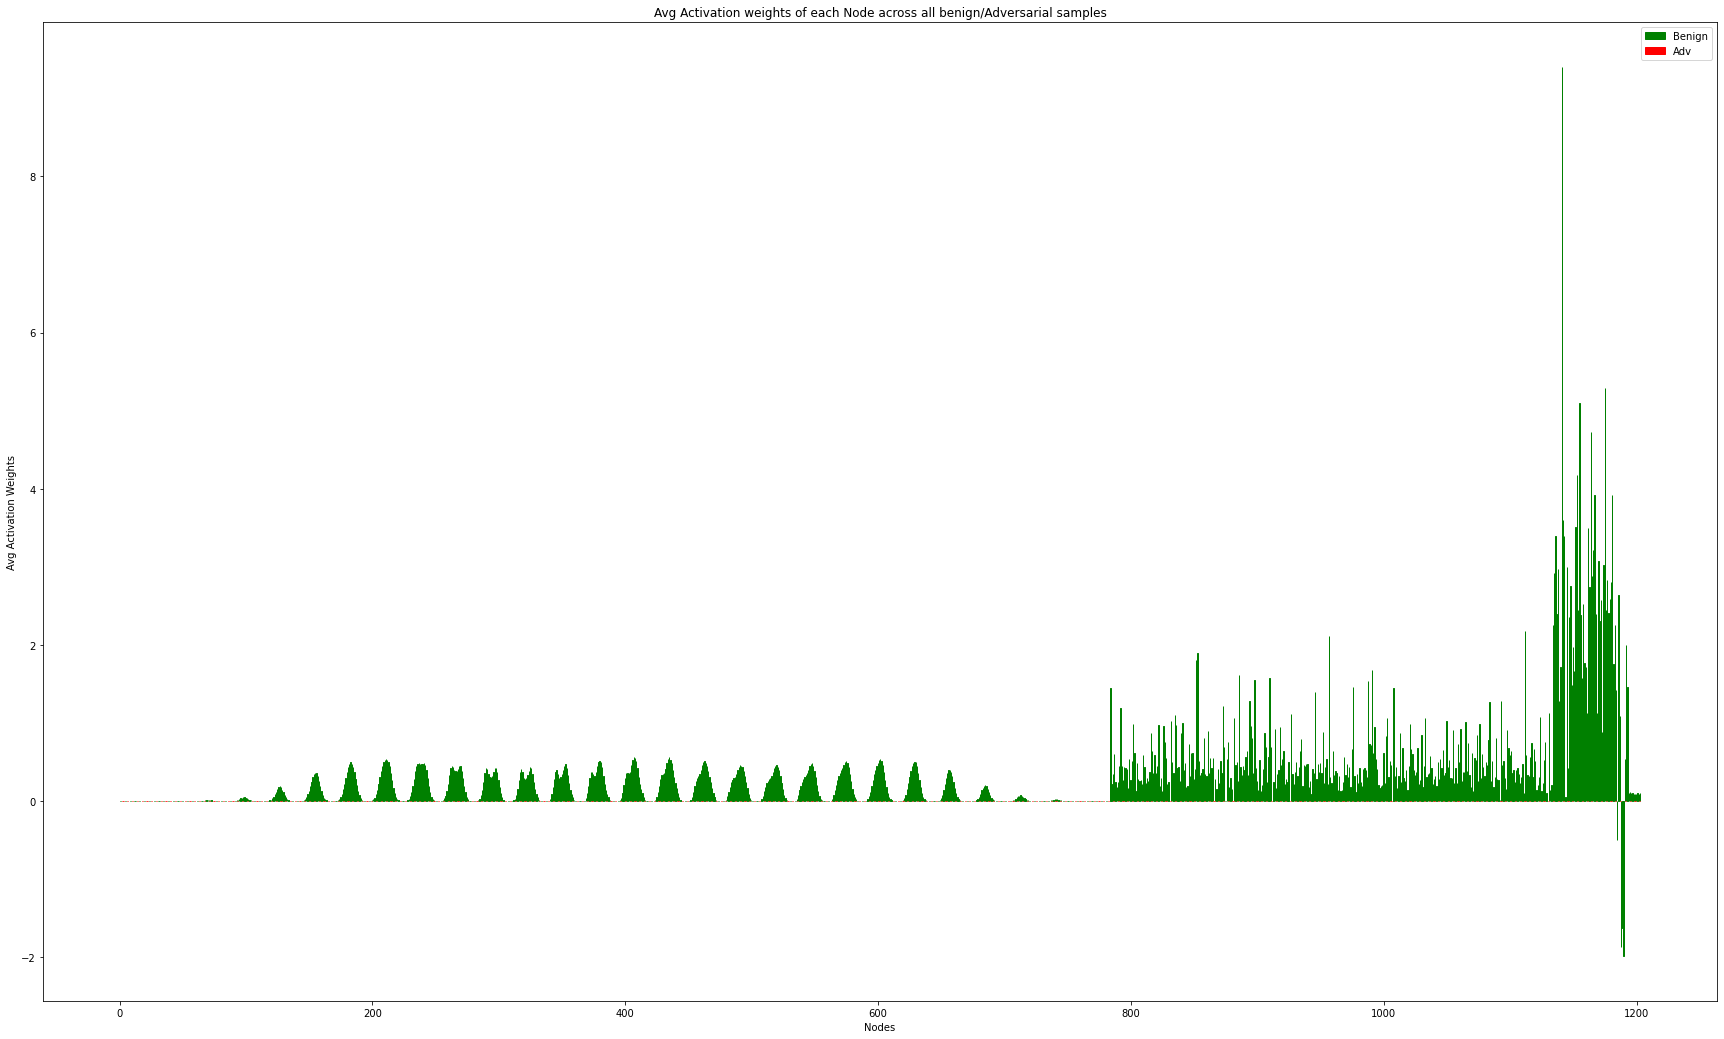

In [ ]:
# plot avg weights of all nodes for only benign data
bar_plot(x_axis,ben_avg_weights,len(adv_avg_weights)*[0], 'Nodes', 'Avg Activation Weights', 'Avg Activation weights of each Node across all benign/Adversarial samples')

Nodes weights have comparable values when samples are benign vs. Adv however they tend to be higher on Adv data

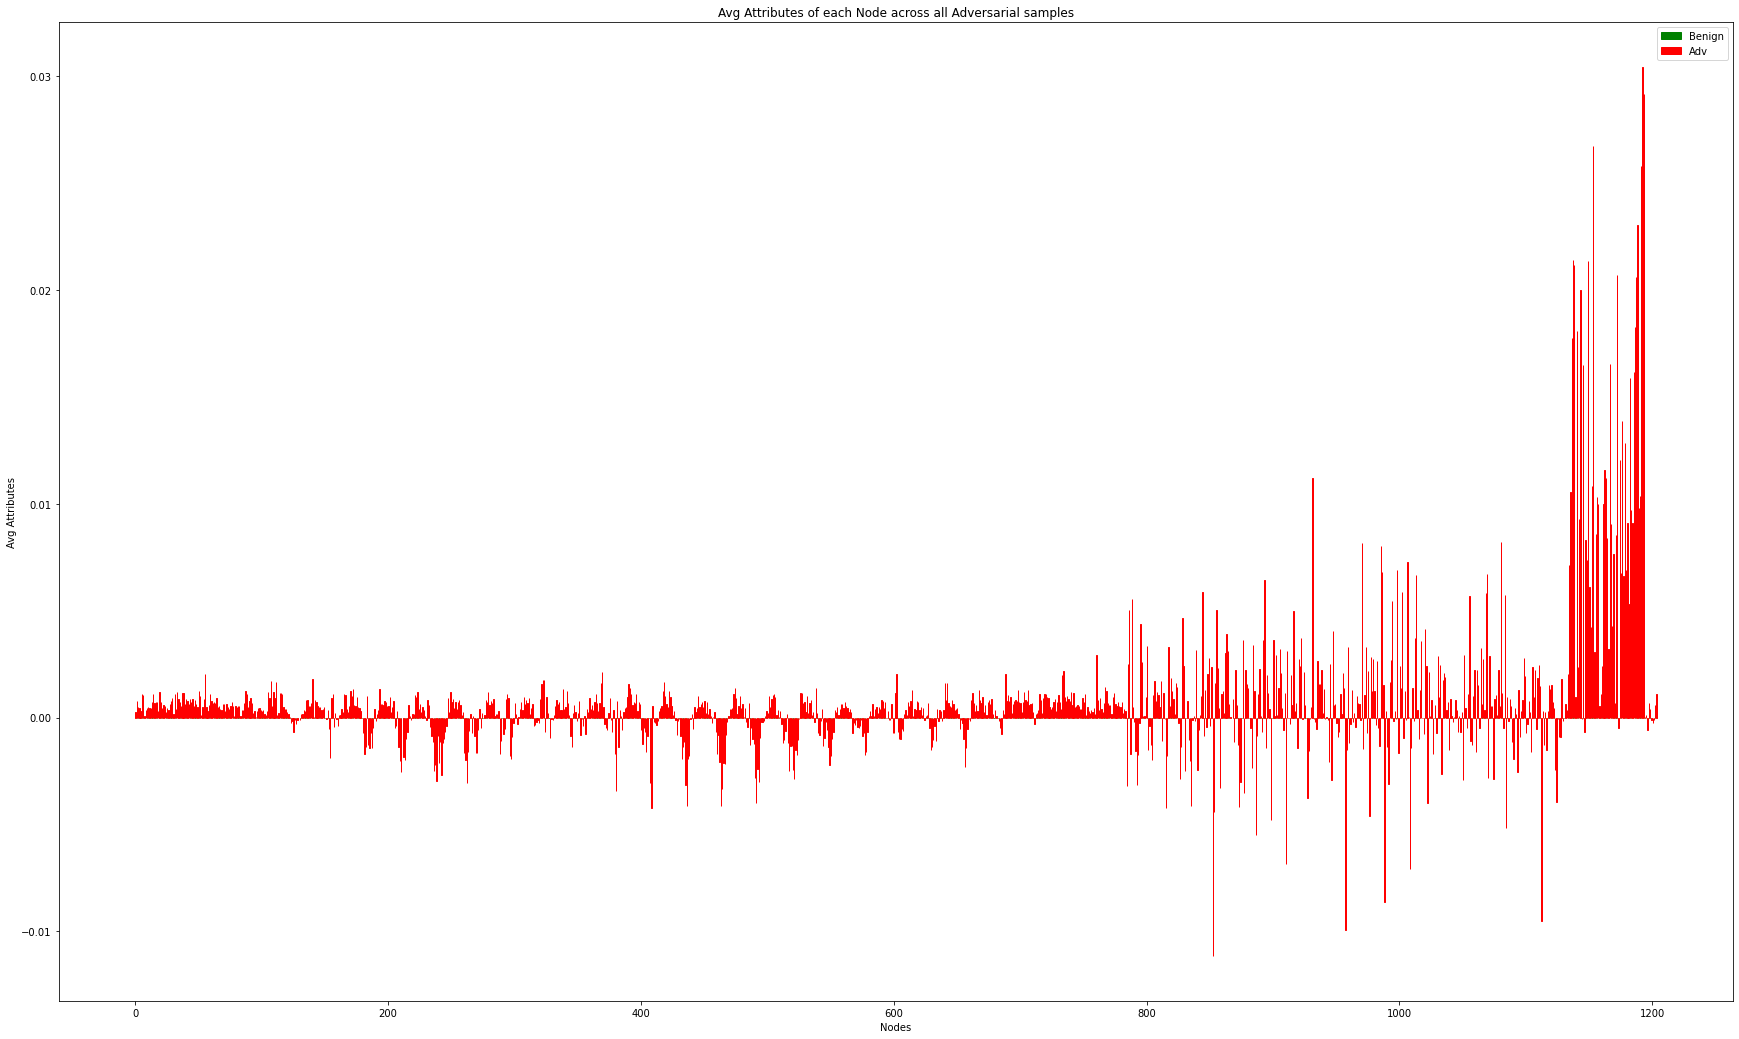

In [ ]:
# plot avg Attributes of all nodes
bar_plot(x_axis,ben_avg_atts,adv_avg_atts, 'Nodes', 'Avg Attributes', 'Avg Attributes of each Node across all Adversarial samples')

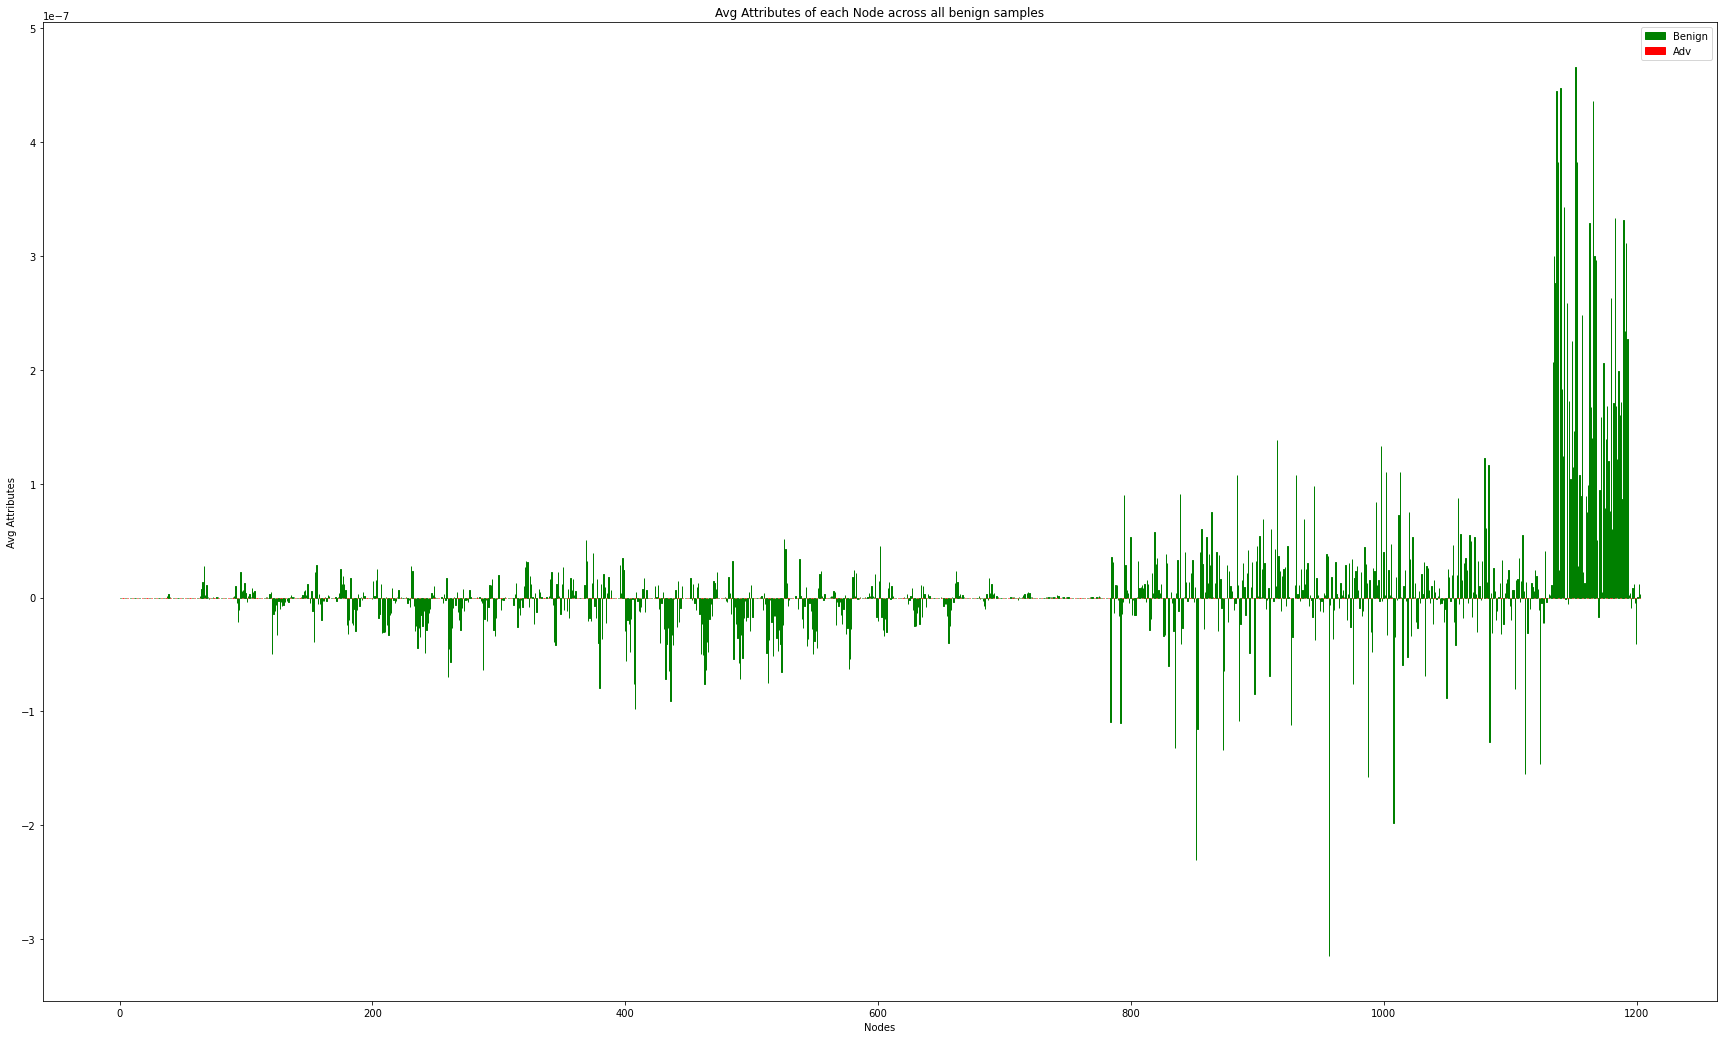

In [ ]:
# plot avg Attributes of all nodes
bar_plot(x_axis,ben_avg_atts,len(adv_avg_atts)*[0], 'Nodes', 'Avg Attributes', 'Avg Attributes of each Node across all benign samples')

Node Attribution values are so much higher when the sample is adv. This is expected since the explanation is performed with respect to the label 1.

To get a clearer look on the most relevant Nodes, we filter those that are irrelevant to the prediction. More precisely, we discard nodes with an average attribute value close to 0

In [ ]:
# select a thresholds
threshold_ben = 0.00000005
threshold_Adv = 0.005

In [ ]:
ben_node_filter = [np.abs(x) > threshold_ben for x in ben_avg_atts]
ben_nodes = [x_axis[i] for i in range(len(x_axis)) if ben_node_filter[i]]
print('Nodes that are relevant to the benign samples are:\n',ben_nodes)
print('\n len = ',len(ben_nodes))

Nodes that are relevant to the benign samples are:
 [260, 262, 288, 369, 380, 401, 407, 408, 432, 435, 436, 462, 463, 464, 486, 490, 491, 493, 513, 517, 524, 526, 577, 578, 784, 792, 795, 800, 819, 830, 835, 839, 852, 853, 856, 860, 864, 873, 874, 884, 886, 898, 902, 905, 910, 911, 916, 927, 931, 937, 945, 957, 976, 988, 994, 998, 1002, 1008, 1012, 1013, 1015, 1019, 1020, 1023, 1033, 1050, 1059, 1061, 1068, 1072, 1080, 1081, 1083, 1084, 1104, 1110, 1112, 1124, 1134, 1135, 1136, 1137, 1138, 1140, 1141, 1142, 1143, 1145, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1155, 1156, 1157, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1171, 1172, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193]

 len =  130


In [ ]:
adv_node_filter = [np.abs(x) > threshold_Adv for x in adv_avg_atts]
adv_nodes = [x_axis[i] for i in range(len(x_axis)) if adv_node_filter[i]]
print('Nodes that are relevant to the Adversarial samples are:\n',adv_nodes)
print('\n len = ',len(adv_nodes))

Nodes that are relevant to the Adversarial samples are:
 [786, 788, 844, 852, 855, 886, 893, 910, 931, 957, 970, 985, 986, 988, 994, 998, 1002, 1006, 1008, 1013, 1055, 1068, 1069, 1080, 1083, 1084, 1112, 1134, 1135, 1136, 1137, 1138, 1140, 1142, 1143, 1145, 1147, 1148, 1149, 1150, 1152, 1153, 1155, 1156, 1157, 1161, 1162, 1163, 1164, 1166, 1167, 1169, 1171, 1172, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193]

 len =  74


In [ ]:
# merge all relavant nodes
nodes = adv_nodes + ben_nodes
nodes = list(set(nodes))
nodes.sort()
print('studied nodes are : \n',nodes)
print('\n len = ',len(nodes))

studied nodes are : 
 [260, 262, 288, 369, 380, 401, 407, 408, 432, 435, 436, 462, 463, 464, 486, 490, 491, 493, 513, 517, 524, 526, 577, 578, 784, 786, 788, 792, 795, 800, 819, 830, 835, 839, 844, 852, 853, 855, 856, 860, 864, 873, 874, 884, 886, 893, 898, 902, 905, 910, 911, 916, 927, 931, 937, 945, 957, 970, 976, 985, 986, 988, 994, 998, 1002, 1006, 1008, 1012, 1013, 1015, 1019, 1020, 1023, 1033, 1050, 1055, 1059, 1061, 1068, 1069, 1072, 1080, 1081, 1083, 1084, 1104, 1110, 1112, 1124, 1134, 1135, 1136, 1137, 1138, 1140, 1141, 1142, 1143, 1145, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1155, 1156, 1157, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1171, 1172, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193]

 len =  141


In [ ]:
ben_avg_atts_filtered = [ben_avg_atts[i] for i in range(len(x_axis)) if i in nodes]
adv_avg_atts_filtered = [adv_avg_atts[i] for i in range(len(x_axis)) if i in nodes]

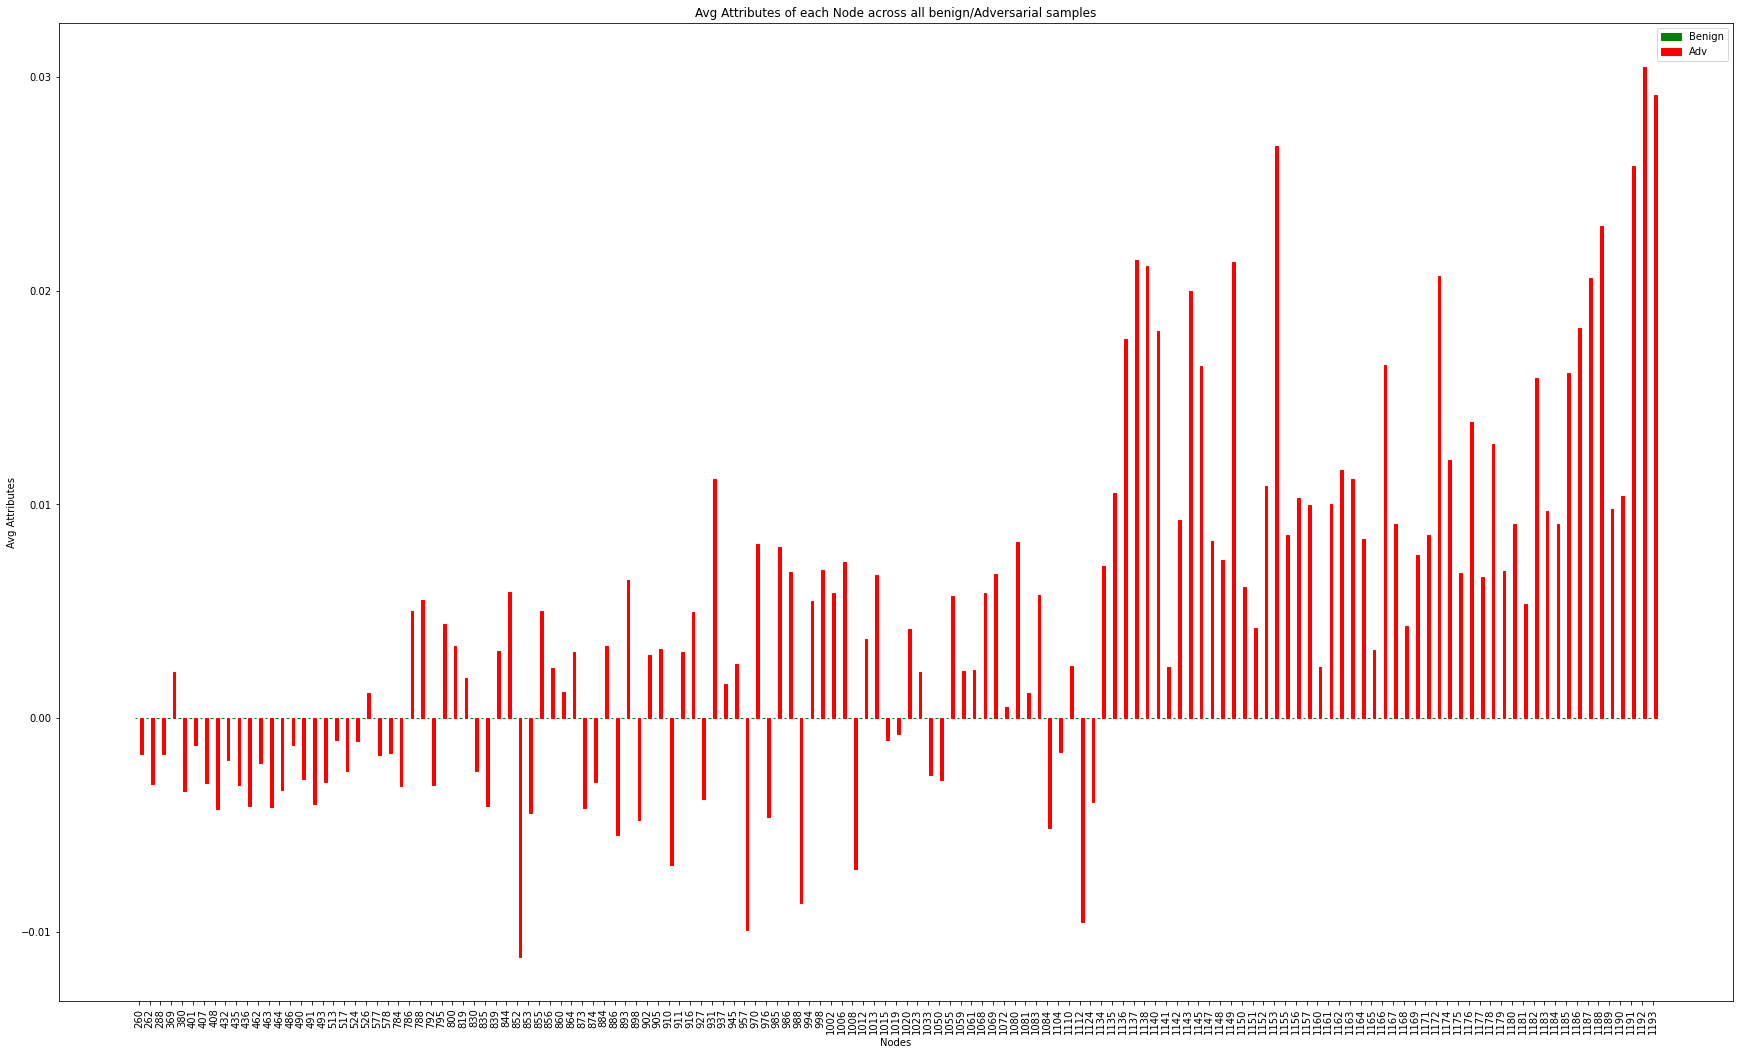

In [ ]:
# plot avg Attributes of all nodes
bar_plot(range(len(nodes)),ben_avg_atts_filtered,adv_avg_atts_filtered, 'Nodes', 'Avg Attributes', 'Avg Attributes of each Node across all benign/Adversarial samples', xticks=nodes)

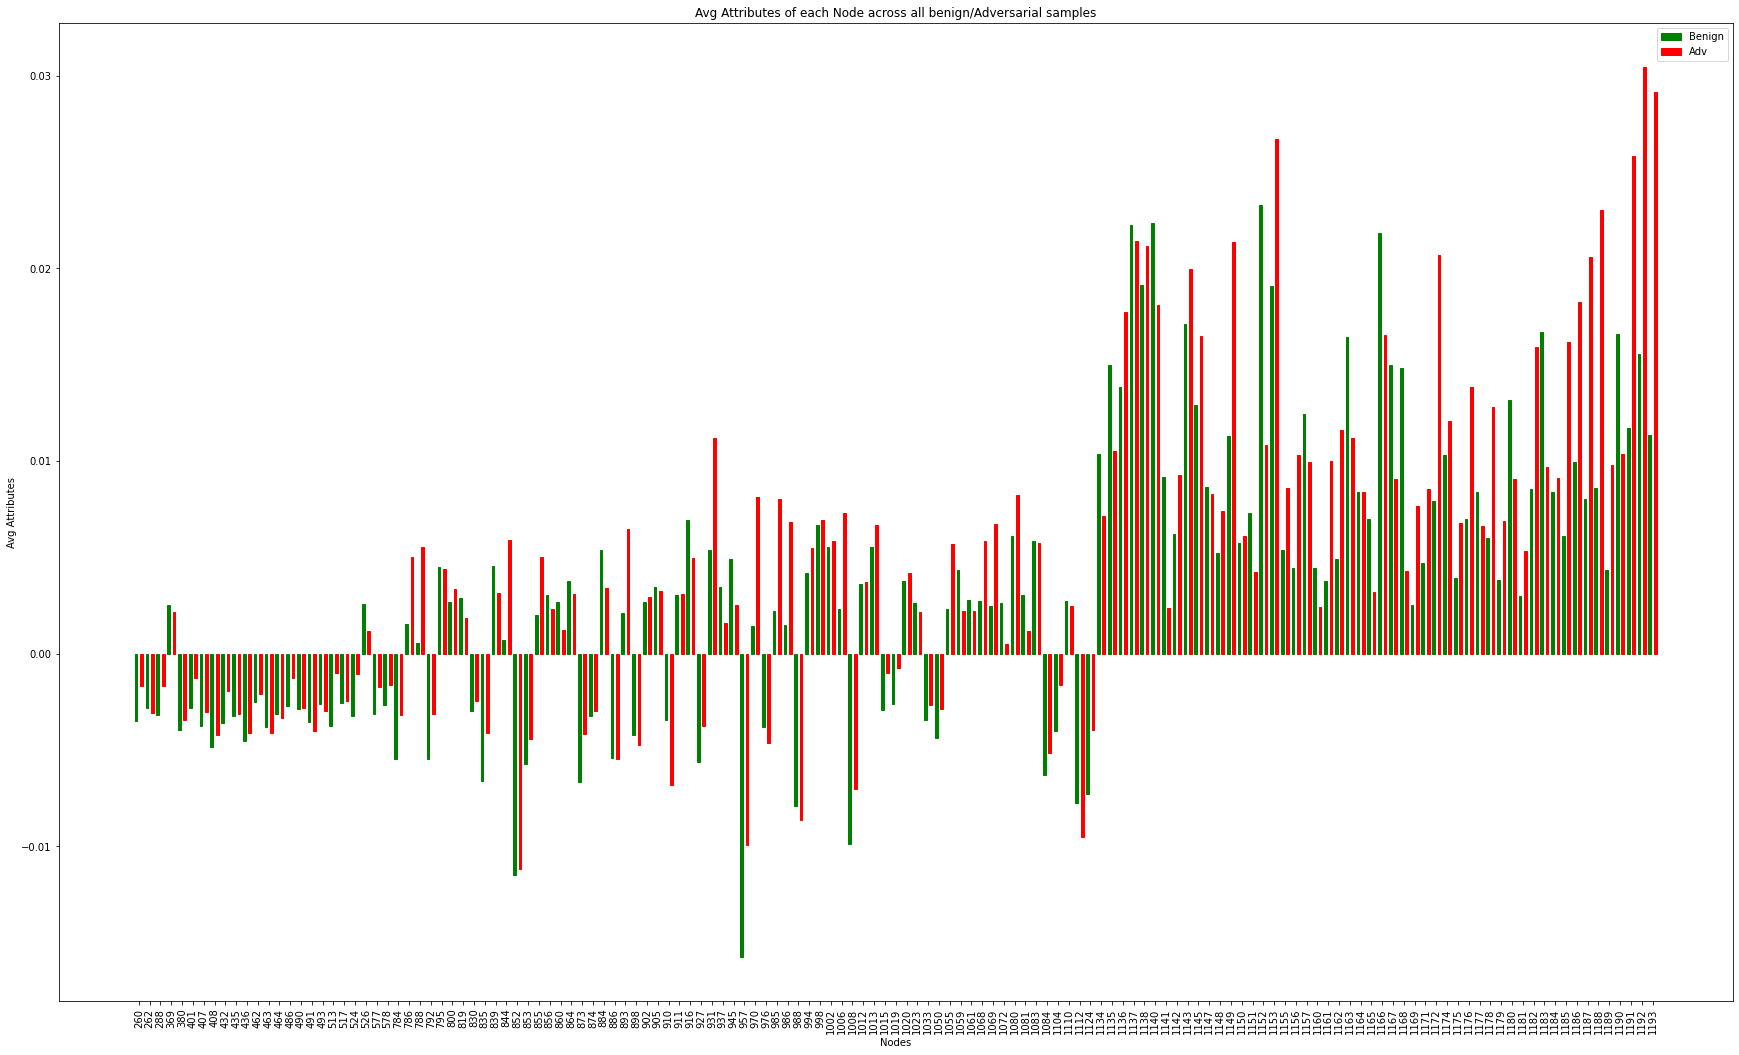

In [ ]:
## rescaling Ben attributions to plot both types of data together
bar_plot(range(len(nodes)),[x*10000*5 for x in ben_avg_atts_filtered],adv_avg_atts_filtered, 'Nodes', 'Avg Attributes', 'Avg Attributes of each Node across all benign/Adversarial samples', xticks=nodes)

**Plotting Attributes range for each relevant node**

In [ ]:
ben_atts_filtered = [ben_atts[i] for i in range(len(x_axis)) if i in nodes]
adv_atts_filtered = [adv_atts[i] for i in range(len(x_axis)) if i in nodes]

In [ ]:
def boxplot(x_axis, y_ben, y_adv, x_label, y_label, title, xticks=None):
     
    # set width of box
    boxWidth = 0.25
    fig1, ax1 = plt.subplots(figsize=(30,18))
    
    # set x positions
    x_ben = [x - boxWidth/2 for x in x_axis]
    x_adv = [x + boxWidth/2 for x in x_axis]
    
    
    plt.title(title)
    plt.xlabel(x_label)
    #plt.ylabel(y_label)
    #if xticks != None:
    #    plt.xticks(x_axis,labels=xticks,rotation='vertical')
    

    #print(y_ben[0].shape)
    # Creating plot
    bx1 = ax1.boxplot(y_ben,notch=True,whis=2,positions=x_ben,widths=boxWidth,patch_artist=True,showfliers=False)
    ax1.set_xticks(x_axis,labels=xticks,rotation=90)
    ax1.set_ylabel(y_label+' Benign')
    plt.setp(bx1["boxes"], facecolor='green',label='Benign')
    
    ax2 = ax1.twinx()
    
    # Creating plot
    bx2 = ax2.boxplot(y_adv,notch=True,whis=2,positions=x_adv,widths=boxWidth,patch_artist=True,showfliers=False)
    ax2.set_xticks(x_axis,labels=xticks,rotation=90)
    ax2.set_ylabel(y_label+' Adversarial')
    plt.setp(bx2["boxes"], facecolor='red',label='Adversarial')
    
    by_label={0: 'Adversarial',
             1: 'Benign'}
    
    # show plot
    plt.show()

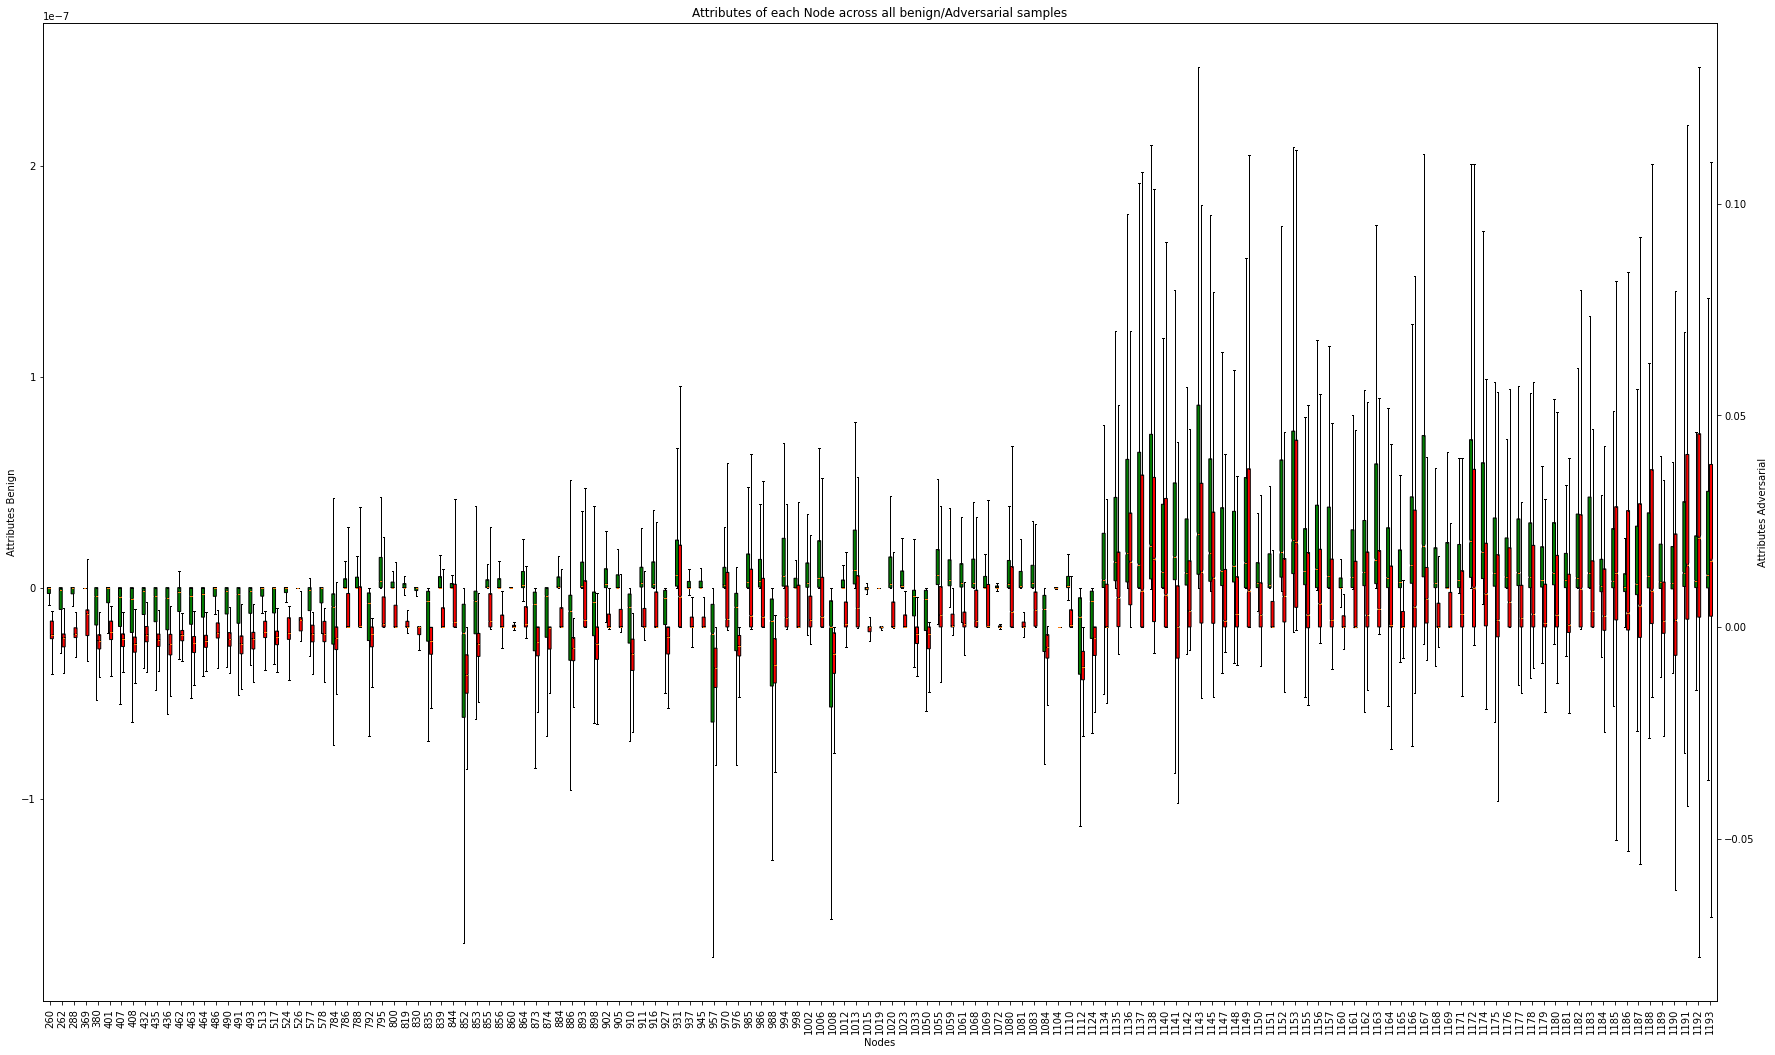

In [ ]:
boxplot(range(len(nodes)),torch.tensor(ben_atts_filtered, device = 'cpu'),torch.tensor(adv_atts_filtered, device = 'cpu'), 'Nodes', 'Attributes', 'Attributes of each Node across all benign/Adversarial samples', xticks=nodes)

In [ ]:
ben_weights_filtered = [ben_weights[i] for i in range(len(x_axis)) if i in nodes]
adv_weights_filtered = [adv_weights[i] for i in range(len(x_axis)) if i in nodes]

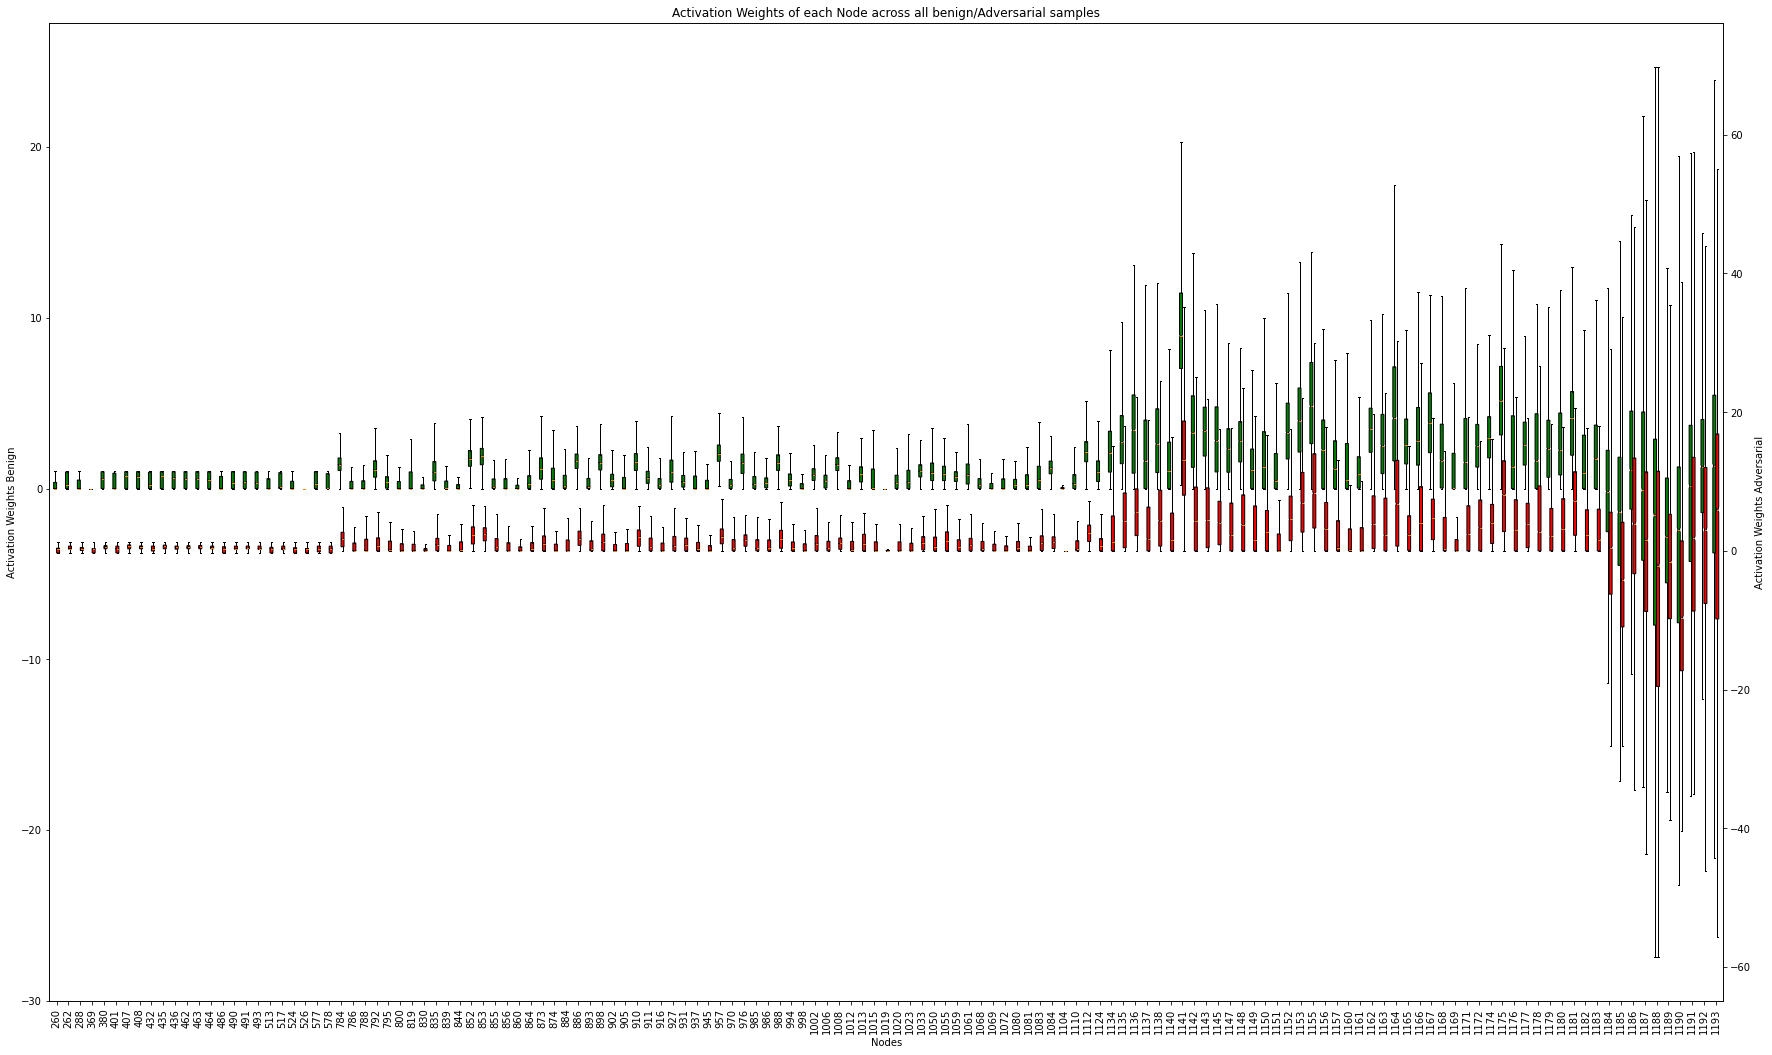

In [ ]:
boxplot(range(len(nodes)),torch.tensor(ben_weights_filtered, device = 'cpu'),torch.tensor(adv_weights_filtered, device = 'cpu'), 'Nodes', 'Activation Weights', 'Activation Weights of each Node across all benign/Adversarial samples', xticks=nodes)